# Spectra-bulding from ek80 files

This is the notebook I used for initial verification and building of the `ek80Spectra.py` file in this directory. The calculations all came from Chris Bassett (UW APL). The goal here was to use pyecholab rather than some legacy matlab scripts to simplify the process of reading ek80 FM data and calculating Sv.

There are 3 versions/parts:
1. A deconstructed version that is arranged to be able to directly compare with Chris' original matlab processing
2. A slightly cleaned up section where I could compare between python implementations, using 1 as a reference to make sure things were still adding up and to be able to compare non-hardcoded windows to 3
3. The `spectra` class, which is now also `ek80Spectra.py`, though I use the notebook to modify

## 1. Testing the math

I moved the alpha calculations and the frequency transform code into functions and both have been verified.

To make sure the math was right, I did this using a specific defined window range to use identical values for the complex voltages. These are hardcoded in the top version here and use the `Example_ComplexVoltages.csv` file in this directory. In Chris' matlab scripts this needs to be hardcoded for the window:

```matlab
specvec = CV{jjj}(1110:1200,1).* range{jjj}(1238:1328,1)
```

In [48]:
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram
import numpy as np
from bs4 import BeautifulSoup as bs
from scipy.signal.windows import tukey
from scipy.fft import fft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def alphaFG(c, pH, T, D, S,f): # requires sound speed (m/s), pH, temp(C), depth(m), salinity(ppt), and nominal frequency(kHz)
    # Attenuation Coefficient is based on Francois and Garrison, 1982 - "Sound absorption based on ocean measurements.
    # Boric Acid Contribution, P1 = 1
    A1=((8.86/c)*(10**(0.78*pH-5)))
    f1=((2.8*((S/35)**0.5))*(10**(4-(1245/(T+273)))))
    # MgSO4 Contribution
    A2=((21.44*(S/c))*(1+(0.025*T)))
    P2=(1-(1.37*(10**-4)*D)+(6.2*(10**-9)*(D**2)))
    f2=((8.17*(10**(8-(1990/(T+273)))))/(1+.0018*(S-35)))
    # Pure water contribution, where A3 is temperature dependent
    if T > 20:
        A3=((3.964*(10**-4))-(1.146*(10**-5)*T)+(1.45*(10**-7)*(T**2))-(6.5*(10**-10)*(T**3)))
    else:
        A3=((4.937*(10**-4))-(2.59*(10**-5)*T)+(9.11*(10**-7)*(T**2))-(1.5*(10**-8)*(T**3)))
    P3=((1-(3.83*(10**-5)*D)) + (4.9*(10**-10)*(D**2)))
    # Calculate and return Alpha
    alpha = (((f**2)*A1*f1)/(((f1**2)) + (f**2)))+ ((A2*P2*f2*(f**2))/((f2**2) + (f**2))) + (A3*P3*(f**2))
    return alpha

def freqtransf(FFTvecin,fsdec,fc): #sampling decimation of band-limited signal
    nfft  = len(FFTvecin)
    FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
    fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
    fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
    if fc > (fsdec/2):
        idxmin      = round((fc-fsdec/2)/fsdec*nfft)-1
    else:
        idxmin      = 1
    FFTvec = FFTvec[idxmin:idxmin+nfft]
    fvec = fvec[idxmin:idxmin+nfft]
    return FFTvec, fvec

In [1]:
rawfiles=['SME80/RWP_2018_deployment_plan-Phase0-D20190727-T081515-0-pp_55-90FM_split.raw']
calFilesXML=['SME80/SME80_FM.xml']
calFilesECS=['SME80/SME80_FM.ecs']

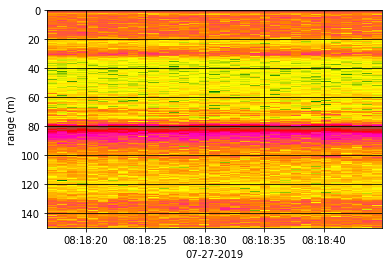

In [4]:
ek80 = EK80.EK80()
ek80.read_raw(rawfiles)
d = ek80.get_channel_data(frequencies=70000)
d = d[70000][0]
d.environment[0:-1] = d.environment[-1]

d_sv = d.get_Sv()
d_power = d.get_power()

fig_1 = figure()
eg = echogram.Echogram(fig_1, d_sv)
show()

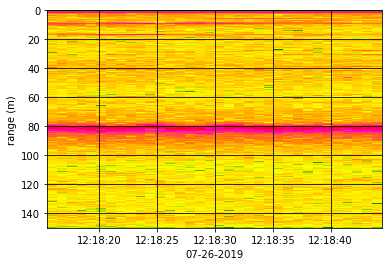

In [73]:
fig_1 = figure()
eg = echogram.Echogram(fig_1, d_power)
show()

In [352]:
class winSetup(): # This was only done as a class so I could match with the arrangement of the matlab structure
    def __init__(self,data):
        self.l = 1 # this is in pings, needs to be implemented such that we can look at multiple pings (mean across pings)
        step = 0.5 # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = data.range[1]-data.range[0]
        maxRange = data.range.max()
        maxRangeClipped = maxRange# - 75
        minRange = 0
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nInds = int(np.ceil(step/deltaRange))
        self.winInds = []
        for h in self.rangeBins:
            self.winInds.append(np.where(abs(data.range-h)==np.min(abs(data.range-h)))[0][0])

In [238]:
win = winSetup(d_power) # setup the window parameters

In [50]:
import pandas as pd
filename = 'Example_ComplexVoltages.csv' #
data = pd.read_csv(filename, sep=",", header=None)
data = np.ravel(data.applymap(lambda s: np.complex(''.join((s.replace('i', 'j')).split()))).values)

In [276]:
ping = 0 # ping number
i = 0 # window number
complexVoltage = np.mean(d.complex,axis=2) # get the complext voltage for each sample from the 4 channels
#cvWindow = complexVoltage[ping][win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the complext voltages in the first window
cvWindow = data[1109:1200] # grab the complext voltages in the first window
#rWindow = d_power.range[win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the ranges of that first window
rWindow = d_power.range[1109:1200] # grab the ranges of that first window
sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 

In [277]:
#b = tukey(win.nInds,0.1)/(np.linalg.norm(tukey(win.nInds,0.1))/np.sqrt(win.nInds)) # build the tukey window with a 10% taper
b = tukey(91,0.1)/(np.linalg.norm(tukey(91,0.1))/np.sqrt(91)) # build the tukey window with a 10% taper
sVector = sVector*b # apply the tukey window
sVector = fft(sVector,win.nfft) # run the fft on the now windowed scaled volltages

In [278]:
FFTvecin = sVector
fsdec = 1/d.sample_interval[0] # sampling rate, parameter value in the config
fc = 70000 # nominal frequency, also a parameter factor, can be d_sv.frequency but currently there's a problem (talk to rick)

In [280]:
FFTvec_tmp, ftmp = freqtransf(FFTvecin,fsdec,fc) # this is a frequency transformation
# calculate alpha for each frequency in our spectra
alpha = [alphaFG(d.environment[0]['sound_speed'],d.environment[0]['acidity'],d.environment[0]['temperature'],d.environment[0]['depth'],d.environment[0]['salinity'],nomf/1000)/1000 for nomf in ftmp]

In [281]:
# This is how we get the data from the calibration xml documents
content = []
with open(calFilesXML[0], "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
calPsi = float(bs_content.find('equivalentbeamangle').get_text())
calPsi = calPsi + 20*np.log10(70000/ftmp)

In [282]:
f = interp1d(calF, calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
ftmp[ftmp< min(calF)] = np.nan
ftmp[ftmp> max(calF)] = np.nan
G = f(ftmp) # Gain interpolated to match the frequency values

In [283]:
dt = 2*(d_power.range[(win.winInds[i]+win.nInds)] - d_power.range[(win.winInds[i])])/d.environment[0]['sound_speed']
pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
zet = d.ZTRANSDUCER # transducer impedance
zer = d.ZTRANSCEIVER # transciever impedance
pTr = d.transmit_power[0] #Transmit power

In [284]:
svtmp = 10*np.log10(pr) +\
   [(2*float(win.rangeBinCenters[i]))*a for a in alpha] - 2*G - calPsi - \
   10*np.log10(dt) +\
   10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
   10*np.log10((zer+zet)/zer) - \
   10*np.log10(d.environment[0]['sound_speed']**3/(32*np.pi**2*ftmp**2))

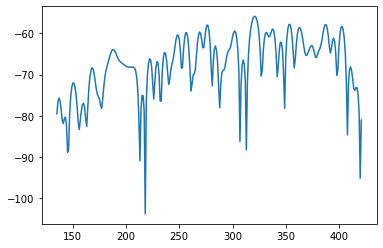

In [285]:
plt.plot(svtmp)

## 2. Same process, but now for checking agains the funtionalized version:

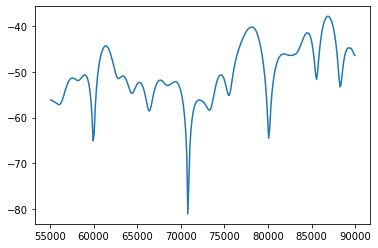

In [89]:
class winSetup():
    def __init__(self,data):
        self.l = 1 # this is in pings, needs to be implemented such that we can look at multiple pings (mean across pings)
        step = 0.5 # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = data.range[1]-data.range[0]
        maxRange = data.range.max()
        maxRangeClipped = maxRange - 75
        minRange = 0
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nInds = int(np.ceil(step/deltaRange))
        self.winInds = []
        for h in self.rangeBins:
            self.winInds.append(np.where(abs(data.range-h)==np.min(abs(data.range-h)))[0][0])

rawfiles=['SME80/RWP_2018_deployment_plan-Phase0-D20190727-T081515-0-pp_55-90FM_split.raw']
calFilesXML=['SME80/SME80_FM.xml']
calFilesECS=['SME80/SME80_FM.ecs']


ek80 = EK80.EK80()
ek80.read_raw(rawfiles)
d = ek80.get_channel_data(frequencies=70000)
d = d[70000][0]
d.environment[0:-1] = d.environment[-1]

d_sv = d.get_Sv()
d_power = d.get_power()

win= winSetup(d_power)

ping = 0 # ping number
i = 12 # window number
complexVoltage = np.mean(d.complex,axis=2) # get the complext voltage for each sample from the 4 channels
cvWindow = complexVoltage[ping][win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the complext voltages in the first window
rWindow = d_power.range[win.winInds[i]:(win.winInds[i]+win.nInds)] # grab the ranges of that first window
sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 

b = tukey(win.nInds,0.1)/(np.linalg.norm(tukey(win.nInds,0.1))/np.sqrt(win.nInds)) # build the tukey window with a 10% taper
sVector = sVector*b # apply the tukey window
sVector = fft(sVector,win.nfft) # run the fft on the now windowed scaled volltages

FFTvecin = sVector
fsdec = 1/d.sample_interval[0] # sampling rate, parameter value in the config
fc = 70000 # nominal frequency, also a parameter factor, can be d_sv.frequency but currently there's a problem (talk to rick)

FFTvec_tmp, ftmp = freqtransf(FFTvecin,fsdec,fc) # this is a frequency transformation
# calculate alpha for each frequency in our spectra
alpha = [alphaFG(d.environment[0]['sound_speed'],d.environment[0]['acidity'],d.environment[0]['temperature'],d.environment[0]['depth'],d.environment[0]['salinity'],nomf/1000)/1000 for nomf in ftmp]

# This is how we get the data from the calibration xml documents
content = []
with open(calFilesXML[0], "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
calPsi = float(bs_content.find('equivalentbeamangle').get_text())
calPsi = calPsi + 20*np.log10(70000/ftmp)

f = interp1d(calF, calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
ftmp[ftmp< min(calF)] = np.nan
ftmp[ftmp> max(calF)] = np.nan
G = f(ftmp) # Gain interpolated to match the frequency values

dt = 2*(d_power.range[(win.winInds[i]+win.nInds)] - d_power.range[(win.winInds[i])])/d.environment[0]['sound_speed']
pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
zet = d.ZTRANSDUCER # transducer impedance
zer = d.ZTRANSCEIVER # transciever impedance
pTr = d.transmit_power[0] #Transmit power
svtmp = 10*np.log10(pr) +\
   [(2*float(win.rangeBinCenters[i]))*a for a in alpha] - 2*G - calPsi - \
   10*np.log10(dt) +\
   10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
   10*np.log10((zer+zet)/zer) - \
   10*np.log10(d.environment[0]['sound_speed']**3/(32*np.pi**2*ftmp**2))

plt.plot(ftmp,svtmp)

## 3. Let's build a class

As with everything else I do, this is kind of a mess but probably only requires a low-medium effort to integrate parts of it into ek80. At least that was the goal.

In [40]:
import os
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram
import numpy as np
from bs4 import BeautifulSoup as bs
from scipy.signal.windows import tukey
from scipy.fft import fft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

class spectra():
    def __init__(self,windowX, windowZ, rawFiles, calFiles=None, freqs=None):
        
        if windowX == 0:
            self.ek80 = EK80.EK80()
            print('Reading raw files...')
            self.ek80.read_raw(rawFiles[0])
            self.freqs = [freqs] if freqs is not None else list(self.ek80.frequency_map.keys())
            self.rawFiles = rawFiles
            self.windowX = 10**10 #make it something absurd
        else:
            self.ek80 = EK80.EK80()
            print('Reading raw files...')
            self.ek80.read_raw(rawFiles)
            self.freqs = [freqs] if freqs is not None else list(self.ek80.frequency_map.keys())
            self.windowX = int(windowX)
        print('Found ',len(self.freqs), 'frequencies:',self.freqs)
        self.windowZ = windowZ
        self.calFiles = calFiles
        self.spectraDict = {}
        
    def calcSpectra(self):
        for self.freq in self.freqs:
            try:
                self.calFile = [cf for cf in self.calFiles if str(int(self.freq)) in cf][0]
                print('Calculating spectra for ', self.freq)
            except:
                print('Skipping ', str(self.freq),', no cal found.')
                continue
            self.__setCal__()
            
            self.spectraDict[self.freq] = {}
            self.data = self.ek80.get_channel_data(frequencies=self.freq)[self.freq][0]
            self.__setWindow__()
            
            self.spectraDict[self.freq]['rangeBinCenters'] = self.rangeBinCenters
            self.spectraDict[self.freq]['rangeBinSize'] = self.windowZ
            self.spectraDict[self.freq]['windowSampleIndex'] = self.winIndsZ
            self.spectraDict[self.freq]['windowPingStart'] = []
            self.spectraDict[self.freq]['windowPingStartTime'] = []
            self.spectraDict[self.freq]['Sv'] = []
            

            print('Calculating spectra for',len(self.winIndsZ), 'vertical windows in', len(self.nwinX),' horizontal windows')
            
            if self.windowX ==10**10:
                npings=0
                for file in self.rawFiles:
                    self.ek80.read_raw(file)
                    self.data = self.ek80.get_channel_data(frequencies=self.freq)[self.freq][0]
                    winSpec = []
                    for i in range(len(self.winIndsZ)):
                        ftmp, svtmp = self.__specMath__(self.winIndsZ[i],0,self.rangeBinCenters[i])
                        winSpec.append(svtmp)
                    self.spectraDict[self.freq]['Sv'].append(winSpec)
                    self.spectraDict[self.freq]['windowPingStart'].append(npings)
                    self.spectraDict[self.freq]['windowPingStartTime'].append(self.data.ping_time[0])
                    npings = npings+self.data.n_pings
            else:
                for winIndX in self.nwinX:
                    winSpec = []
                    for i in range(len(self.winIndsZ)):
                        ftmp, svtmp = self.__specMath__(self.winIndsZ[i],winIndX,self.rangeBinCenters[i])
                        winSpec.append(svtmp)
                    self.spectraDict[self.freq]['Sv'].append(winSpec)
                    self.spectraDict[self.freq]['windowPingStart'].append(self.windowX*winIndX)
                    self.spectraDict[self.freq]['windowPingStartTime'].append(self.data.ping_time[self.windowX*winIndX])
            
            self.spectraDict[self.freq]['frequency'] = ftmp
            

    def __setWindow__(self):
        self.range = self.data.get_power().range # we need to do this since range isn't carried in the 'raw'
        if self.windowX == 10**10:
            self.nwinX = [0]
        else:
            self.nwinX = np.arange(int(np.ceil(self.data.n_pings/self.windowX)))
        step = self.windowZ # this is in meters
        self.nfft = 2**9 # make this variable, take a window length across the channels, whats the max number of datapoints, thats the minimum fft for all channels
        deltaRange = self.range[1]-self.range[0]
        maxRange = self.range.max()
        maxRangeClipped = maxRange-75 # these shouldn't be hardcoded but it's just for clipping
        minRange = 3 # these shouldn't be hardcoded but it's just for clipping
        self.rangeBins = np.arange(minRange,maxRangeClipped+step,step)
        self.rangeBinCenters = self.rangeBins + step/2
        self.nIndsZ = int(np.ceil(step/deltaRange))
        self.winIndsZ = []
        for h in self.rangeBins:
            self.winIndsZ.append(np.where(abs(self.range-h)==np.min(abs(self.range-h)))[0][0])
        
    def __setCal__(self):
        # Currently the read_ecs in echolab doesn't work so I'm going to do it myself from the xml. I'm not going to spend time on this since
        # when working, echolab will have the cal values stored for each channel already. Currently all of this can only handle one channel because the cals
        # are all independent (i.e., 1 xml file for each channel). The reac_ecs implementation would fix this.
        if self.calFile is None:
            # This is just a place holder since there are some issue in the calibration object
            self.data.get_calibration().equivalent_beam_angle[0]
            self.data.get_calibration().frequency # this is empty? 
            self.data.get_calibration().gain[0] # this is a single value for every ping but needs to be a table
        else:
            name, extension = os.path.splitext(self.calFile)
            print('Grabbing cal data from ',extension, 'file')
            if extension == '.xml':
                content = []
                with open(self.calFile, "r") as file:
                    # Read each line in the file, readlines() returns a list of lines
                    content = file.readlines()
                    # Combine the lines in the list into a string
                    content = "".join(content)
                    bs_content = bs(content, "lxml")

                self.calF = [float(f) for f in bs_content.find('calibrationresults').find('frequency').get_text().split(';')]
                self.calG = [float(f) for f in bs_content.find('calibrationresults').find('gain').get_text().split(';')]
                self.calPsi = float(bs_content.find('equivalentbeamangle').get_text())

            # ECS can go here, but see comments above. 
            
            
    def __specMath__(self,winIndZ,winIndX,rangeBinCenter):
        complexVoltage = np.mean(self.data.complex,axis=2) # get the complext voltage for each sample from the 4 channels
        #curComplex = 
        cvWindow = (np.mean(complexVoltage[self.windowX*(winIndX):self.windowX*(winIndX+1)],axis=0))[winIndZ:(winIndZ+self.nIndsZ)] # grab the complext voltages in the first window
        self.range = self.data.get_power().range
        rWindow = self.data.get_power().range[winIndZ:(winIndZ+self.nIndsZ)] # grab the ranges of that first window
        sVector = cvWindow*rWindow #scale the complex voltage by range to account for spreading 
        b = tukey(self.nIndsZ,0.1)/(np.linalg.norm(tukey(self.nIndsZ,0.1))/np.sqrt(self.nIndsZ)) # build the tukey window with a 10% taper
        sVector = sVector*b # apply the tukey window
        sVector = fft(sVector,self.nfft) # run the fft on the now windowed scaled volltages
        FFTvecin = sVector
        fsdec = 1/self.data.sample_interval[0] # sampling rate, parameter value in the config
        FFTvec_tmp, ftmp = self.freqtransf(FFTvecin,fsdec,self.freq) # this is a frequency transformation   
        env = self.data.environment[self.data.environment != np.array(None)][0]
        self.alpha = [self.alphaFG(env['sound_speed'],env['acidity'],env['temperature'],env['depth'],env['salinity'],nomf/1000)/1000 for nomf in ftmp]
        
        f = interp1d(self.calF, self.calG,fill_value=np.nan) # 1-d interpolation of the calibration gains so that they fit the size of our frequency vector
        ftmp[ftmp< min(self.calF)] = np.nan
        ftmp[ftmp> max(self.calF)] = np.nan
        calPsi = self.calPsi + 20*np.log10(self.freq/ftmp)
        G = f(ftmp) # Gain interpolated to match the frequency values
        dt = 2*(self.range[winIndZ+self.nIndsZ] - self.range[winIndZ])/env['sound_speed']
        
        pr = np.abs(FFTvec_tmp)**2 # note sure I get what this is but I think it's the absolute value of the square of the complex data
        zet = self.data.ZTRANSDUCER # transducer impedance
        zer = self.data.ZTRANSCEIVER # transciever impedance
        pTr = self.data.transmit_power[0] #Transmit power

        svtmp = 10*np.log10(pr) +\
           [(2*rangeBinCenter*a) for a in self.alpha] - 2*G - calPsi - \
           10*np.log10(dt) +\
           10*np.log10(4/zet/pTr/(2*np.sqrt(2))**2) +\
           10*np.log10((zer+zet)/zer) - \
           10*np.log10(env['sound_speed']**3/(32*np.pi**2*ftmp**2))
        return ftmp, svtmp
      
        
    def alphaFG(self,c, pH, T, D, S,f): # requires sound speed (m/s), pH, temp(C), depth(m), salinity(ppt), and nominal frequency(kHz)
        # Attenuation Coefficient is based on Francois and Garrison, 1982 - "Sound absorption based on ocean measurements.
        # Boric Acid Contribution, P1 = 1
        A1=((8.86/c)*(10**(0.78*pH-5)))
        f1=((2.8*((S/35)**0.5))*(10**(4-(1245/(T+273)))))
        # MgSO4 Contribution
        A2=((21.44*(S/c))*(1+(0.025*T)))
        P2=(1-(1.37*(10**-4)*D)+(6.2*(10**-9)*(D**2)))
        f2=((8.17*(10**(8-(1990/(T+273)))))/(1+.0018*(S-35)))
        # Pure water contribution, where A3 is temperature dependent
        if T > 20:
            A3=((3.964*(10**-4))-(1.146*(10**-5)*T)+(1.45*(10**-7)*(T**2))-(6.5*(10**-10)*(T**3)))
        else:
            A3=((4.937*(10**-4))-(2.59*(10**-5)*T)+(9.11*(10**-7)*(T**2))-(1.5*(10**-8)*(T**3)))
        P3=((1-(3.83*(10**-5)*D)) + (4.9*(10**-10)*(D**2)))
        # Calculate and return Alpha
        alpha = (((f**2)*A1*f1)/(((f1**2)) + (f**2)))+ ((A2*P2*f2*(f**2))/((f2**2) + (f**2))) + (A3*P3*(f**2))
        return alpha

    def freqtransf(self,FFTvecin,fsdec,fc): #sampling decimation of band-limited signal
        nfft  = len(FFTvecin)
        FFTvec  = FFTvec = np.ravel([FFTvecin, FFTvecin, FFTvecin])
        fvec  = fsdec*np.linspace(0,1-(1/nfft),nfft)
        fvec   = np.ravel([fvec,fsdec+fvec,(2*fsdec)+fvec])
        if fc > (fsdec/2):
            idxmin      = round((fc-fsdec/2)/fsdec*nfft)-1
        else:
            idxmin      = 0
        FFTvec = FFTvec[idxmin:idxmin+nfft]
        fvec = fvec[idxmin:idxmin+nfft]
        return FFTvec, fvec
    
    
    def plotSpec(self,windowX,windowZ):
        fig = plt.figure(figsize=(10,5))
        for freq in self.spectraDict.keys():
            plt.plot(self.spectraDict[freq]['frequency'],self.spectraDict[freq]['Sv'][windowX][windowZ],color='dimgrey')
            plt.title(self.spectraDict[freq]['windowPingStartTime'][windowX].astype(str)+'\n'+\
                      str(self.spectraDict[freq]['rangeBinCenters'][windowZ]-self.windowZ/2)+\
                      ' to '+str(self.spectraDict[freq]['rangeBinCenters'][windowZ]+self.windowZ/2)+'m range')
        plt.xlabel('Frequency')
        plt.ylabel('Sv')
        plt.show()

Reading raw files...
Found  1 frequencies: [70000.0]
Calculating spectra for  70000.0
Grabbing cal data from  .xml file
Calculating spectra for 16 vertical windows in 1  horizontal windows


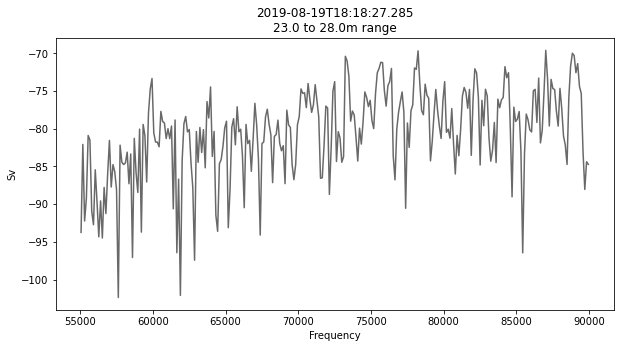

In [43]:
# Example using data with a single frequency and one cal file (SME mooring data)
from glob import glob
files = glob('D:/SME80/RWP*FM_split.raw')
rawFiles = files[0:1]
calFilesXML=['D:/SME80/SME80_70000FM.xml']

s = spectra(0, 5, rawFiles, calFilesXML)
s.calcSpectra()
s.plotSpec(0,4)

Reading raw files...
Found  4 frequencies: [38000.0, 70000.0, 120000.0, 200000.0]
Calculating spectra for  38000.0
Grabbing cal data from  .xml file
Calculating spectra for 26 vertical windows in 1  horizontal windows
Calculating spectra for  70000.0
Grabbing cal data from  .xml file
Calculating spectra for 26 vertical windows in 1  horizontal windows
Calculating spectra for  120000.0
Grabbing cal data from  .xml file
Calculating spectra for 26 vertical windows in 1  horizontal windows
Skipping  200000.0 , no cal found.


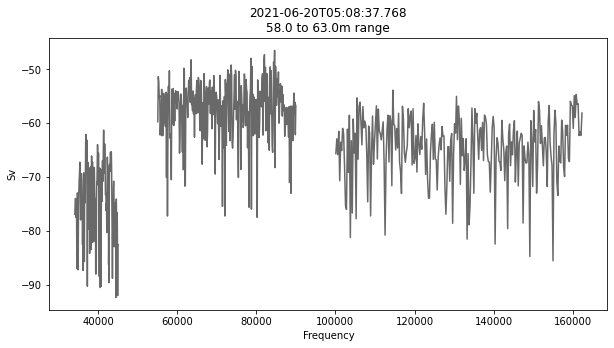

In [46]:
# An example using multifrequency and multiple cal files (Urmy data)
from glob import glob
files = glob('D:/FMProcessing/example/urmy/splitFiles/*FM_split.raw')
rawFiles = files[0:1]
calFilesXML=glob('D:/FMProcessing/example/cals/*.xml')

s = spectra(0, 5, rawFiles, calFilesXML)
s.calcSpectra()
s.plotSpec(0,11)